#   Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
#   Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [3]:
!pip3 install torch==1.3.1+cpu torchvision==0.4.2+cpu -f https://download.pytorch.org/whl/torch_stable.html


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cpu/torch-1.3.1%2Bcpu-cp37-cp37m-linux_x86_64.whl (111.8 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.4.2%2Bcpu-cp37-cp37m-linux_x86_64.whl (13.5 MB)


In [4]:
#   Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
  Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
#  Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [6]:
# Retrieve the sagemaker session
sagemaker_session=sagemaker.Session()

# Retrieve the sagemaker S3 bucket, region and role
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

# Set the prefix in the above bucket
prefix = "dogImages"
# Begin upload
inputs = sagemaker_session.upload_data(path="./dogImages", bucket=bucket, key_prefix=prefix)


Default Bucket: sagemaker-us-east-1-415073778672
AWS Region: us-east-1
RoleArn: arn:aws:iam::415073778672:role/service-role/AmazonSageMaker-ExecutionRole-20220118T222113


In [7]:
inputs = f's3://{bucket}/dogImages'
inputs

's3://sagemaker-us-east-1-415073778672/dogImages'

In [8]:
train_images_path = f"s3://{bucket}/dogImages/train"
print(train_images_path)
val_images_path = f"s3://{bucket}/dogImages/valid"
print(val_images_path)

s3://sagemaker-us-east-1-415073778672/dogImages/train
s3://sagemaker-us-east-1-415073778672/dogImages/valid


## Hyperparameter Tuning
** ** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
#  Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "batch-size": sagemaker.tuner.CategoricalParameter([32, 64, 128, 256, 512]),
    "lr": sagemaker.tuner.ContinuousParameter(0.01, 0.1),
    "epochs": sagemaker.tuner.IntegerParameter(2, 4)
}

objective_metric_name = "average test accuracy"
objective_type = "Maximize"

metric_definitions = [{"Name": "average test accuracy", "Regex": "Test set: Average accuracy: ([0-9\\.]+)"}]

In [10]:
from sagemaker.pytorch import PyTorch

#  Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
) #  Your estimator here

tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type
) #  Your HP tuner here

In [11]:
# estimator.fit({"train": inputs})

In [12]:
tuner.fit({"train": inputs})

In [13]:
#   Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

In [14]:
best_hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), 
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']
                  }
best_hyperparameters

In [15]:
best_hyperparameters = {'batch-size': '512', 'lr': '0.026305482032806977', 'epochs': '4'}

## Model Profiling and Debugging
  Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [38]:
#   Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1"
    }
)

In [39]:
#   Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name='dogImageEstimator',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters=best_hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)#   Your estimator here

estimator.fit({"train": train_images_path, "test": val_images_path}, wait=True)

2022-01-20 10:42:32 Starting - Starting the training job...
2022-01-20 10:42:59 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-01-20 10:43:59 Starting - Preparing the instances for training.........
2022-01-20 10:45:29 Downloading - Downloading input data.........
2022-01-20 10:47:00 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-20 10:47:07,619 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-20 10:47:07,622 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-20 10:47:07,630 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-20 10:47:13,856 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-20

In [40]:
#   Plot a debugging output.
import smdebug

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
trial = smdebug.trials.create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-01-20 11:21:37.864 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-415073778672/dogImageEstimator-2022-01-20-10-42-32-089/debug-output
[2022-01-20 11:21:38.875 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-20 11:21:39.920 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [41]:
from smdebug.core.modes import ModeKeys

len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

6

In [42]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

8

In [43]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


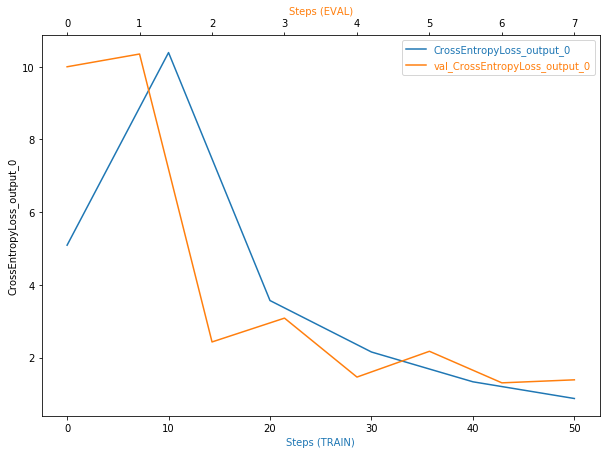

In [45]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [46]:
#   Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-415073778672/dogImageEstimator-2022-01-20-10-42-32-089/rule-output'

In [47]:
!aws s3 ls {rule_output_path} --recursive

2022-01-20 11:13:01     364830 dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-20 11:13:00     211898 dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-20 11:12:56        192 dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-20 11:12:56        200 dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-20 11:12:56       1901 dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-20 11:12:56        127 dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-20 11:12:56        199 dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/prof

In [48]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-415073778672/dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-415073778672/dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-415073778672/dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-415073778672/dogImageEstimator-2022-01-20-10-42-32-089/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-415073778672/do

In [49]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [50]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [57]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=estimator.model_data, 
                             role=role, 
                             entry_point='inference.py', 
                             py_version='py36',
                             framework_version='1.8')


predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

------!

In [58]:
from sagemaker.serializers import IdentitySerializer
predictor.serializer = IdentitySerializer("image/jpeg")

In [59]:
from PIL import Image
from IPython.display import Image as ImageDisplay
import io

def identify_dog(image_path):    
    buf = io.BytesIO()
    Image.open(image_path).save(buf, format="JPEG")
    response = predictor.predict(buf.getvalue())
    
    return response

In [61]:
response = identify_dog("dogImages/test/BigLee.jpg")

In [62]:
import numpy as np
np.argmax(response, 1)

array([6])

In [63]:
#   Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()